### Задача

#### Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
#### Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [40]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy import stats

In [41]:
# Подключимся к ClickHouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [43]:
# Выгрузим необходимые данные за период проведения тестирования
q = """
select 
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-12-02' and toDate(time) <= '2022-12-08' 
    and exp_group in (0,1,2,3)
group by exp_group, user_id    
"""
df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,2,131473,14,134,0.104478
3,3,123580,13,48,0.270833
4,2,32420,26,128,0.203125


In [44]:
# Посчитаем глобальный CTR контрольных групп 
global_ctr_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [45]:
# Разобьем на группы
group_0 = df[df.exp_group == 0].copy()
group_1 = df[df.exp_group == 1].copy()
group_2 = df[df.exp_group == 2].copy()
group_3 = df[df.exp_group == 3].copy()

In [32]:
# Добавим колонку линеаризированных лайков
group_0['linearized_likes'] = group_0['likes'] - (global_ctr_0 * group_0['views'])
group_1['linearized_likes'] = group_1['likes'] - (global_ctr_1 * group_1['views'])
group_2['linearized_likes'] = group_2['likes'] - (global_ctr_1 * group_2['views'])
group_3['linearized_likes'] = group_3['likes'] - (global_ctr_0 * group_3['views'])

In [50]:
# Соберем все в единый датасет
new_df = pd.concat([group_0, group_1, group_2, group_3], ignore_index=True)
new_df.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,0,30319,21,110,0.190909,-1.905973
1,0,7626,14,39,0.358974,5.878791
2,0,111277,2,13,0.153846,-0.707070
3,0,27199,4,34,0.117647,-3.080028
4,0,3450,10,42,0.238095,1.254083


In [63]:
# Проведем t-test для с использованием CTR для групп 0 и 3
stats.ttest_ind(new_df[new_df.exp_group == 0].ctr,
                new_df[new_df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [64]:
# Проведем t-test для с использованием линеаризированных лайков для групп 0 и 3
stats.ttest_ind(new_df[new_df.exp_group == 0].linearized_likes,
                new_df[new_df.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [65]:
# Проведем t-test для с использованием CTR для групп 1 и 2
stats.ttest_ind(new_df[new_df.exp_group == 1].ctr,
                new_df[new_df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [54]:
# Проведем t-test для с использованием линеаризированных лайков для групп 1 и 2
stats.ttest_ind(new_df[new_df.exp_group == 1].linearized_likes,
                new_df[new_df.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

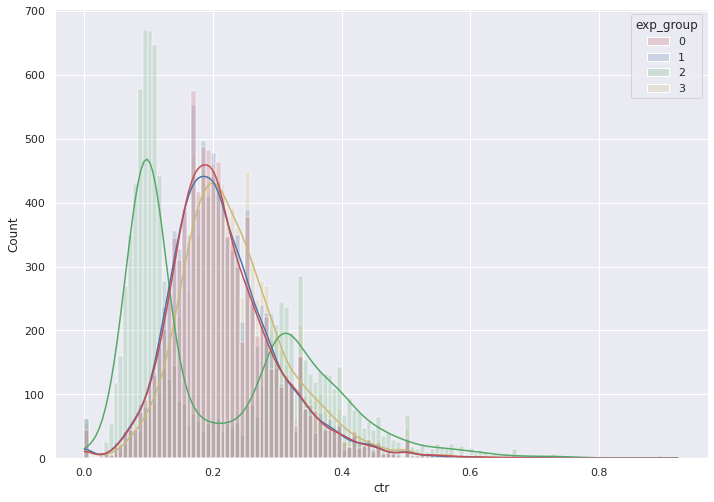

In [59]:
# Построим график распределения обычного CTR по группам
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = new_df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b', 'g', 'y'],
              alpha=0.2,
              kde=True)

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

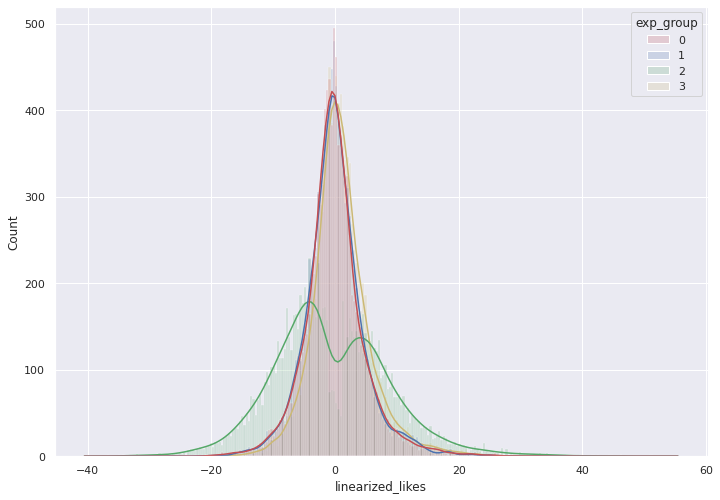

In [66]:
# Построим график распределения линеаризированных лайков по группам
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = new_df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b', 'g', 'y'],
              alpha=0.2,
              kde=True)

#### Применение t-теста с использованием линеаризированных лайков p-value значительно уменьшился, а при проведении теста между группами 1 и 2 мы смогли отклонить нулевую гипотезу, чего не получилось сделать при сравнении поюзерного CTR.
#### Графики линеаризированных лайков в каждых группах практически похожи на нормальные, кроме группы 2, график которой все также похож на бимодальное распределение.